# XAUUSD

In [1]:
import quandl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os

import warnings
import logging

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from column_transformers.technical_indicators import (
    MacdSignal,
    StochRsiSignal
)

In [2]:
xau_ratios = [
    "WGC/GOLD_DAILY_USD"
#     "WGC/GOLD_DAILY_EUR",
#     "WGC/GOLD_DAILY_TRY",
#     "WGC/GOLD_DAILY_JPY",
#     "WGC/GOLD_DAILY_GBP",
#     "WGC/GOLD_DAILY_CAD",
#     "WGC/GOLD_DAILY_CHF",
#     "WGC/GOLD_DAILY_VND",
#     "WGC/GOLD_DAILY_KRW",
#     "WGC/GOLD_DAILY_RUB",
#     "WGC/GOLD_DAILY_AUD",
]

economic_indc = []

### Quandl data terms

Anyone seeking to use this code must first apply for an account with [Quandl](https://www.quandl.com) in order to receive an valid authetitciation key.

In [3]:
DIR_NAME = os.path.abspath(os.path.join(os.getcwd(), '..'))
FILEPATH = os.path.join(DIR_NAME, "auth.txt")

with open(FILEPATH, "r") as f:
    authtoken = f.read();

# Retrieve Data

In [4]:
xau_df_dict = {}

for ratio in tqdm(xau_ratios):
    name = ratio.lower().replace("/", "_")

    # get the ratio dataframe
    df = quandl.get(ratio, authtoken=authtoken, start_date = "1979-01-01")
    df.columns = ["price"]
    
    # check for missing business days 
    if pd.infer_freq(df.index) != "B":
        logging.warn("Datetime frequency is not Business Days")
    
    xau_df_dict[name] = df

100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


## Volatility

In [5]:
annualization_factor = 252.
window_size = [5, 20, 60, 120, 252]

for ratio, df in tqdm(xau_df_dict.items()):
    start_date, end_date = df.index[0], df.index[-1]
    full_range = pd.date_range(start_date, end_date, freq = "B")
    
    if not np.array_equal(df.index, pd.date_range(start_date, end_date, freq="B")):
        logging.warning("\n{} is missing business days".format(ratio))

    for window in window_size:
        df['{}d_market_vol'.format(window)] = np.sqrt(
            (annualization_factor/window) * df['price'].rolling(window).var(ddof=0))

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


## Quandl Features

In [6]:
features = [
    "FRED/T10Y2Y",
    "RATEINF/INFLATION_USA",
]

In [7]:
for ratio, df in xau_df_dict.items():
    for feature in features:
        col_name = feature.lower().replace('/', '_')
        
        # get quandl features. `end_date` is set to df.index[-1] to match the price data
        data = quandl.get(feature, authtoken=authtoken, start_date = "1979-01-01", end_date = df.index[-1])
        start_date, end_date = data.index[0], data.index[-1]

        # Some features contain missing data. To best simulate how the data would be ingested
        # realtime, the current value is forward filled. This achieved by resampling.
        if not np.array_equal(data.index, pd.date_range(start_date, end_date, freq="B")):
            logging.warning("\n\t{} is missing business days".format(feature))
                    
        df[col_name] = data
    
    df[:] = df.ffill()

	FRED/T10Y2Y is missing business days
	RATEINF/INFLATION_USA is missing business days


## Technical indicator features

In [8]:
import talib

technical_indicators= {
    "MACD" : ("macd", "macdsignal", "macdhist"),
    "STOCHRSI" : ("fastk", "fastd"),
    "MOM" : ("real"),
    "APO" : ('real')
}

for ratio, df in xau_df_dict.items():
    
    # talib requires market price data. starting price of $1 is taken
    # since absolute values are not important (preprocess scaling)
    price = df['price'].values

    for indicator, indicator_type in technical_indicators.items():
        # Return the result for each indicator
        result = getattr(talib, indicator)(price)

        if isinstance(result, np.ndarray):
            df[indicator.lower()] = result
        else:
            for f, r in zip(indicator_type, result):
                if f == indicator.lower():
                    df["{}".format(indicator.lower())] = r
                else:
                    df["{}_{}".format(indicator.lower(), f)] = r

## Data preporocessing 

In [14]:
from split._split import TrainValidateTest

data = xau_df_dict['wgc_gold_daily_usd']
data['target'] = data['price'].shift(-1).pct_change()
data.dropna(inplace = True)

X = data.drop(['price', 'target'], axis = 1)
y = (data['target'] > 0).astype(int)
    
split = TrainValidateTest(0.7, 0.15, 0.15)
X_train, X_valid,  X_test, y_train, y_valid,  y_test = split.transform(X, y)

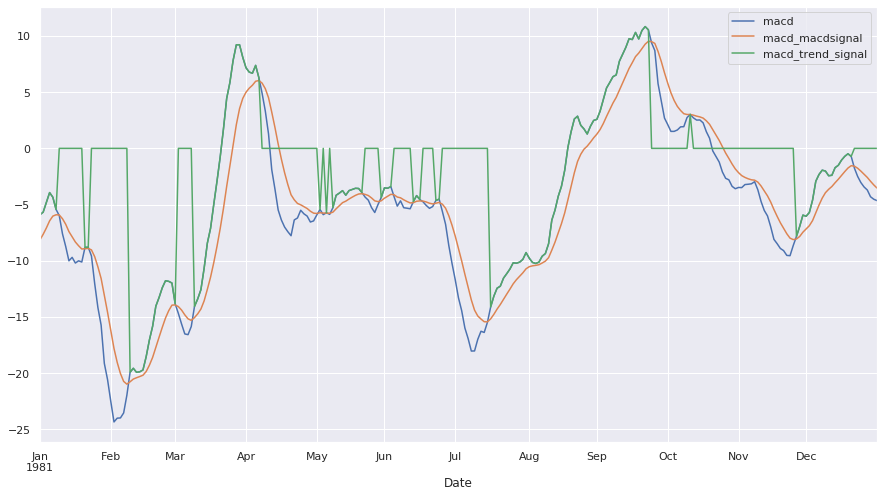

In [15]:
df = X_train

pipeline = Pipeline([
     ('macd_ud_signal', MacdSignal()),
     ('stoch_ud_signal', StochRsiSignal())
])

df = pipeline.fit_transform(df)

sns.set(rc={'figure.figsize':(15, 8)})
df.loc['1981', ['macd', 'macd_macdsignal', 'macd_trend_signal']].plot()

In [42]:
scalar = StandardScaler()
scalar.fit(split_data["X_train"])

scaled_split_data = {name : scalar.transform(df) if "X" in name else df for name, df in split_data.items()}

In [43]:
n_days = scaled_split_data['X_train'].shape[0]
n_features = scaled_split_data['X_train'].shape[1]

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 20,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [30, 100, 250, 500, 1000]

In [44]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(scaled_split_data['X_train'], scaled_split_data["y_train"])
    
    train_score.append(clf.score(scaled_split_data['X_train'], scaled_split_data["y_train"].values))
    valid_score.append(clf.score(scaled_split_data["X_valid"], scaled_split_data["y_valid"].values))
    
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [00:13<00:00,  3.28s/Model]


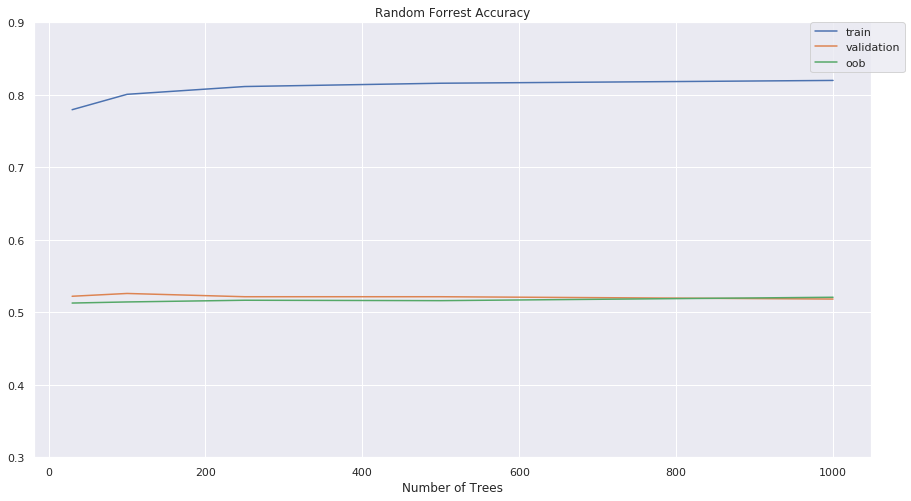

In [45]:
def plot(xs, ys, labels, title='', x_label='', y_label=''):
    for x, y, label in zip(xs, ys, labels):
        plt.ylim((0.3, 0.9))
        plt.plot(x, y, label=label)
        
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.show()

plot([n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

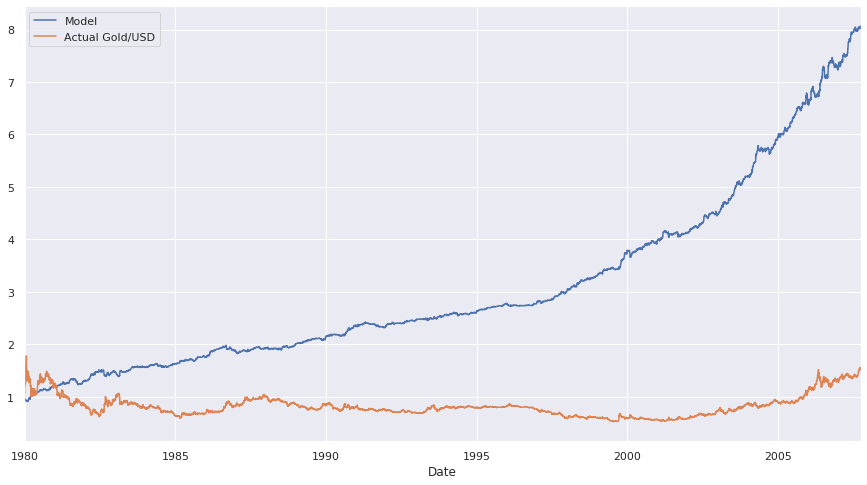

In [46]:
prob_array=[-1,1]
alpha_score = clf.predict_proba(scaled_split_data['X_train']).dot(np.array(prob_array))

# calculate daily returns
alpha_return = alpha_score * data.loc[split_data['X_train'].index, 'target'].shift(-1) * 1.827852605657414
xau_usd_return = data.loc[split_data['X_train'].index, 'target']

# calculate cumulative performance
alpha_perf = (1 + alpha_return).cumprod()
xau_usd_per = (1 + xau_usd_return).cumprod()

#alpha_return.plot()
alpha_sharpe = (np.sqrt(252.) * alpha_return.mean()) / alpha_return.std() 
xau_usd_sharpe = (np.sqrt(252.) * xau_usd_return.mean()) / xau_usd_return.std() 

alpha_perf.plot()
xau_usd_per.plot()

xau_usd_return.mean() / alpha_return.mean() 
sns.set(rc={'figure.figsize':(15, 8)})
plt.legend(labels = ['Model', 'Actual Gold/USD'])